In [2]:
import os
import torch
import torchvision
import torchinfo
import pandas as pd
from torch.utils import data
from torch import nn
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional

In [3]:
def try_gpu(i=0): #@save
    """Return gpu(i) if exists, otherwise return cpu().
    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [4]:
print(try_gpu())

cuda:0


In [5]:
# 获取下标映射
def get_map() -> dict:
    object_map = {}
    with open("object_map.txt","r",encoding = 'utf-8') as file:
        for line in file:
            name,idx = line.split()
            object_map[name] = int(idx)
    return object_map

In [6]:
object_map = get_map()
print(object_map)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [7]:
# 读取数据集即标签
def load_data(data_path = 'train') -> tuple:
    """获取原始的img和对应的labels"""
    train_nums = 50000
    train_labels = pd.read_csv('trainLabels.csv')
    mode = torchvision.io.image.ImageReadMode.RGB # 设置模型读入为RGB!!!
    img_array = []
    labels_array = []

    object_map = get_map()
    for i in range(train_nums):
        labels_array.append(object_map[train_labels.iloc[i,1]])
        img_array.append(torchvision.io.read_image(
            os.path.join(data_path,str(i + 1) + '.png'),mode
        ))
    return img_array,labels_array # 返回的是list格式
    
img_array,labels_array = load_data()

**第一种获得数据迭代器的方式**

通过构造TensorDataset的方式，这个方式的缺点就是传入构造Dataset的数据需要是tensor格式，不够灵活，具体实现如下

In [8]:
# 构造为tensor
labels_array = torch.tensor(labels_array)
img_array = torch.stack(img_array,dim = 0)

In [9]:
print(type(img_array),img_array.shape,img_array.dtype)
print(type(labels_array),labels_array.shape,labels_array.dtype)

<class 'torch.Tensor'> torch.Size([50000, 3, 32, 32]) torch.uint8
<class 'torch.Tensor'> torch.Size([50000]) torch.int64


In [10]:
def make_data_iter(arrays,batch_size = 64) -> data.DataLoader:
    """获得数据迭代器"""
    data_arrays = data.TensorDataset(*arrays) # 构造Dataset
    return data.DataLoader(data_arrays,batch_size,shuffle = True) # 注意第一个参数不要给成了data_arrays

train_iter = make_data_iter((img_array,labels_array))
print(type(train_iter))
for x,y in train_iter:
    print(x.shape,y.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([64, 3, 32, 32]) torch.Size([64])


**第二种获得数据迭代器的方式**

自定义自己的Dataset类，继承自data.Dataset，允许更加灵活的数据集格式

In [11]:
class MyDataset(data.Dataset):
    """自定义的Dataset类，加载图片数据集"""
    def __init__(self,features,labels):
        self.transform = torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ) # RGB格式的通道归一化参数
        self.obj2idx = get_map()
        self.idx2obj = [key for key in self.obj2idx.keys()]
        self.obj_nums = len(self.idx2obj)
        self.features = [self.normalize_img(feature) for feature in features]
        # print(torch.tensor(labels).dtype)
        self.labels = functional.one_hot(torch.tensor(labels),self.obj_nums).to(torch.float32)
        print(f"load {len(self.labels)} images!")

    def normalize_img(self,img):
        """图像归一化"""
        return self.transform(img.float() / 255)
    
    def __getitem__(self, index):
        """定义数据迭代，即下标访问类"""
        feature,label = self.features[index],self.labels[index]
        return feature,label
    
    def __len__(self):
        """定义类的长度"""
        return len(self.features)

In [12]:
img_array,labels_array = load_data()

In [13]:
batch_size = 64
dataset = MyDataset(img_array,labels_array)
train_iter = data.DataLoader(dataset,batch_size,shuffle = True)
for X,Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

load 50000 images!
torch.Size([64, 3, 32, 32])
torch.Size([64, 10])


In [14]:
print(dataset.idx2obj[0])

airplane


**下面开始模型搭建及模型训练**

**尝试1：3层卷积网络**

In [15]:
# 定义网络
net = nn.Sequential(
    nn.Conv2d(3,10,17),
    nn.ReLU(),
    nn.Conv2d(10,10,9),
    nn.ReLU(),
    nn.Conv2d(10,10,5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(160,10),
    nn.Softmax(dim = 1)
)

# 定义损失函数
loss_fn = nn.CrossEntropyLoss()

# 定义超参数
num_epochs = 30
lr = 3e-5

In [16]:
def train(net : nn.Sequential,train_iter,lr,num_epochs,loss_fn):
    """训练函数"""
    # devices_nums = torch.cuda.device_count()
    # devices = []
    # for i in range(devices_nums):
    #     devices.append(try_gpu(i = i))
    device = try_gpu(i = 0)
    net = net.to(device)
    net.train()
    optimzer = torch.optim.Adam(net.parameters(),lr = lr)
    loss_plt = []
    for epoch in range(num_epochs):
        loss_temp = 0
        total_nums = 0
        loop = tqdm(enumerate(train_iter),total = len(train_iter))
        for batch_idx,batch in loop:
            X,Y = batch
            X = X.to(device)
            Y = Y.to(device)
            total_nums += X.shape[0]

            optimzer.zero_grad()
            y_pred = net(X)
            loss = loss_fn(y_pred,Y)
            loss.sum().backward()
            optimzer.step()

            loss_temp += loss.sum().item()
            loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
            loop.set_postfix({"LOSS" : loss_temp / total_nums})
        loss_plt.append(loss_temp / total_nums)
    return loss_plt
        

In [17]:
loss_plt = train(net,train_iter,lr,num_epochs,loss_fn)

Epoch [29/30]: 100%|██████████| 782/782 [00:07<00:00, 109.60it/s, LOSS=0.0319]


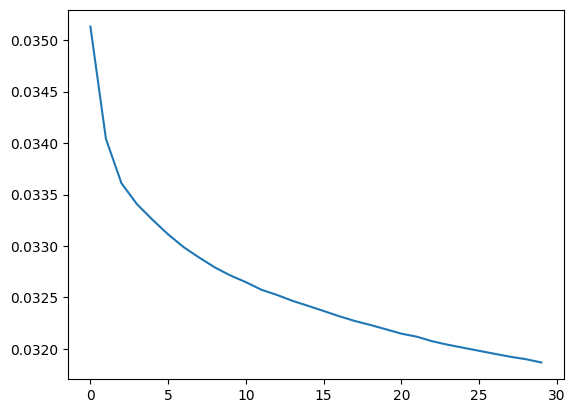

In [18]:
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [19]:
torch.save(net,"models/3.pt")

In [20]:
kkkk = torch.tensor([1,2,3])
kkkk.unsqueeze

<function Tensor.unsqueeze>

In [21]:
def normalize_img(img):
    transform = torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ) # RGB格式的通道归一化参数
    return transform(img.float() / 255)

def count_accurancy(net,train_iter):
    device = try_gpu(i = 0)
    net.eval()
    net.to(device)
    total_nums = 0
    ans = 0
    loop = tqdm(train_iter,total = len(train_iter),desc = "Eval")
    for X,Y in loop:
        total_nums += X.shape[0]
        X = X.to(device)
        Y = Y.to(device).argmax(dim = 1)
        y_pred = net(X).argmax(dim = 1)
        ans += (y_pred == Y).sum().item()
    return ans / total_nums

In [23]:
net = torch.load('models/3.pt',weights_only = False)
accurancy = count_accurancy(net,train_iter)
print(f"acc in train dataset:{accurancy}")

Eval:   0%|          | 0/782 [00:00<?, ?it/s]

Eval: 100%|██████████| 782/782 [00:04<00:00, 176.98it/s]

acc in train dataset:0.4241


In [25]:
def load_test(data_path = 'test'):
    mode = torchvision.io.image.ImageReadMode.RGB # 设置模型读入为RGB!!!
    test_arrays = []
    test_nums = 300000
    for i in range(test_nums):
        test_arrays.append(torchvision.io.read_image(
            os.path.join(data_path,str(i + 1) + '.png'),mode
        ))
    return test_arrays

In [ ]:
class TestDataset(data.Dataset):
    """测试的自定义数据集，无labels"""
    def __init__(self,features):
        self.transform = torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ) # RGB格式的通道归一化参数
        self.features = [self.normalize_img(feature) for feature in features]
        # print(torch.tensor(labels).dtype)
        print(f"load {len(self.features)} images!")

    def normalize_img(self,img):
        """图像归一化"""
        return self.transform(img.float() / 255)
    
    def __getitem__(self, index):
        """定义数据迭代，即下标访问类"""
        feature = self.features[index]
        return feature
    
    def __len__(self):
        """定义类的长度"""
        return len(self.features)
        

def predict(net,test_iter,idx2obj):
    """测试集上预测推理"""
    device = try_gpu(i = 0)
    net.eval()
    net.to(device)
    loop = tqdm(test_iter,desc = "Predict")
    idx = 0
    with open ("result.txt","w",encoding = 'utf-8') as file:
        for X in loop:
            X = X.to(device)
            pred = net(X).argmax(dim = 1)
            for k in pred:
                idx += 1
                file.write(str(idx) + "," + idx2obj[k.item()] + "\n")
        

In [27]:
test_arrays = load_test()

In [31]:
test_dataset = TestDataset(test_arrays)

load 300000 images!


In [34]:
test_iter = data.DataLoader(test_dataset,batch_size = 64)

In [47]:
predict(net,test_iter,dataset.idx2obj)

Predict: 100%|██████████| 4688/4688 [00:14<00:00, 321.73it/s]
